In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Veri yükleme
train_df = pd.read_csv('PM_train.csv')
test_df = pd.read_csv('PM_test.csv')
truth_df = pd.read_csv('PM_truth.csv')

In [5]:
# Veri ön işleme
def preprocess_data(df):
    df = df.drop(['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], axis=1)
    last_cycles = df.groupby('id')['cycle'].max().reset_index()
    last_cycles.columns = ['id', 'max_cycle']
    df = pd.merge(df, last_cycles, on='id', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [6]:
# Özellik seçimi
features = ['setting1', 'setting2', 'cycle'] + [f's{i}' for i in range(2, 22) if i not in [5, 10, 16, 18, 19]]
X = train_df[features]
y = train_df['RUL']

In [7]:
# Veriyi böl
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Veriyi ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
# Random Forest modelini oluştur ve eğit
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [10]:

# Validation seti üzerinde tahminler
val_predictions = model.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

print(f'Validation RMSE: {val_rmse:.4f}')
print(f'Validation R-squared: {val_r2:.4f}')

Validation RMSE: 35.6483
Validation R-squared: 0.7219


In [11]:
# Test verisi için tahminler
X_test = test_df[features]
X_test_scaled = scaler.transform(X_test)
test_df['RUL_predicted'] = model.predict(X_test_scaled)

In [12]:
# Her motor için son tahmin
final_predictions = test_df.groupby('id')['RUL_predicted'].last().reset_index()
final_predictions = pd.merge(final_predictions, truth_df, on='id', how='left')

In [13]:
# Truth verisindeki gerçek RUL değerlerini kullan
if 'RUL' in truth_df.columns:
    true_rul_column = 'RUL'
elif 'cycle' in truth_df.columns:
    true_rul_column = 'cycle'
    final_predictions[true_rul_column] = final_predictions[true_rul_column].astype(float)
else:
    raise ValueError("Truth verisinde RUL veya cycle sütunu bulunamadı.")

In [14]:
# Performans değerlendirme
mse = mean_squared_error(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(final_predictions[true_rul_column], final_predictions['RUL_predicted'])

print(f'Test RMSE: {rmse:.4f}')
print(f'Test R-squared: {r2:.4f}')

Test RMSE: 24.7599
Test R-squared: 0.6450


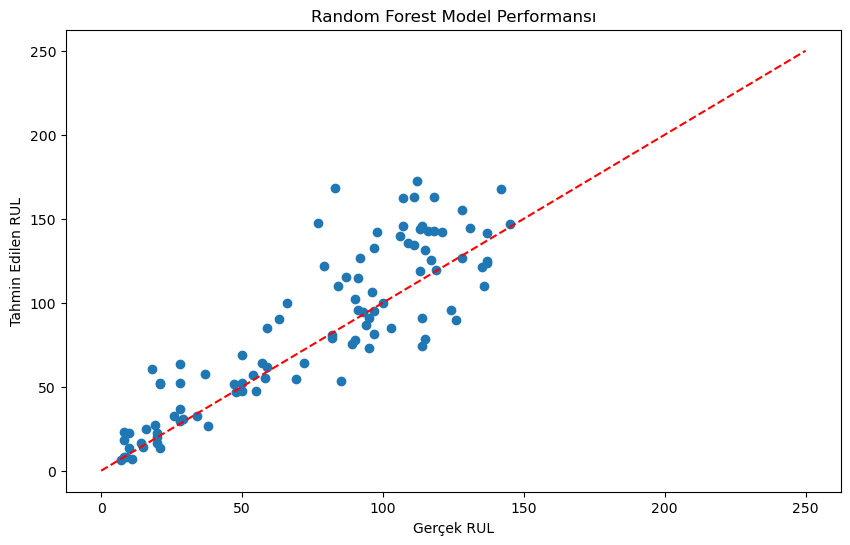

In [15]:
# Tahmin vs Gerçek değer grafiği
plt.figure(figsize=(10, 6))
plt.scatter(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
plt.plot([0, 250], [0, 250], 'r--')
plt.xlabel('Gerçek RUL')
plt.ylabel('Tahmin Edilen RUL')
plt.title('Random Forest Model Performansı')
plt.show()

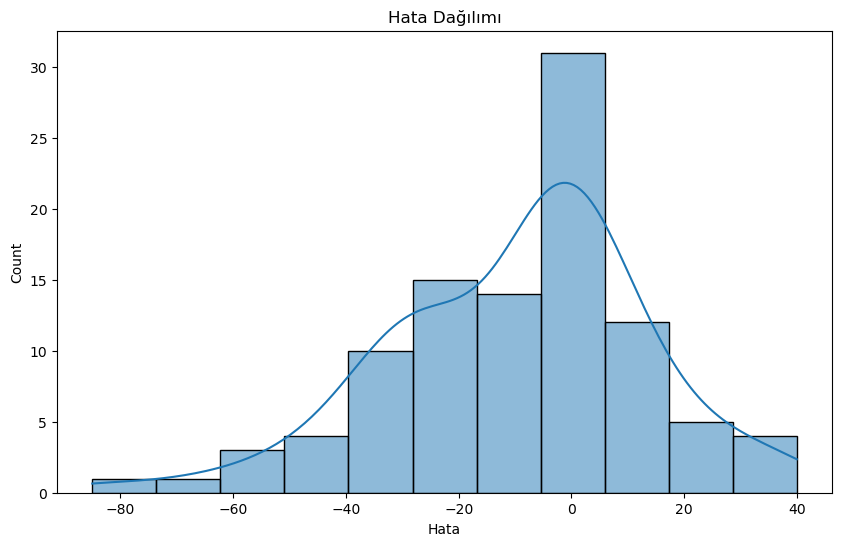

In [16]:
# Hata analizi
final_predictions['error'] = final_predictions[true_rul_column] - final_predictions['RUL_predicted']
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions['error'], kde=True)
plt.title('Hata Dağılımı')
plt.xlabel('Hata')
plt.show()

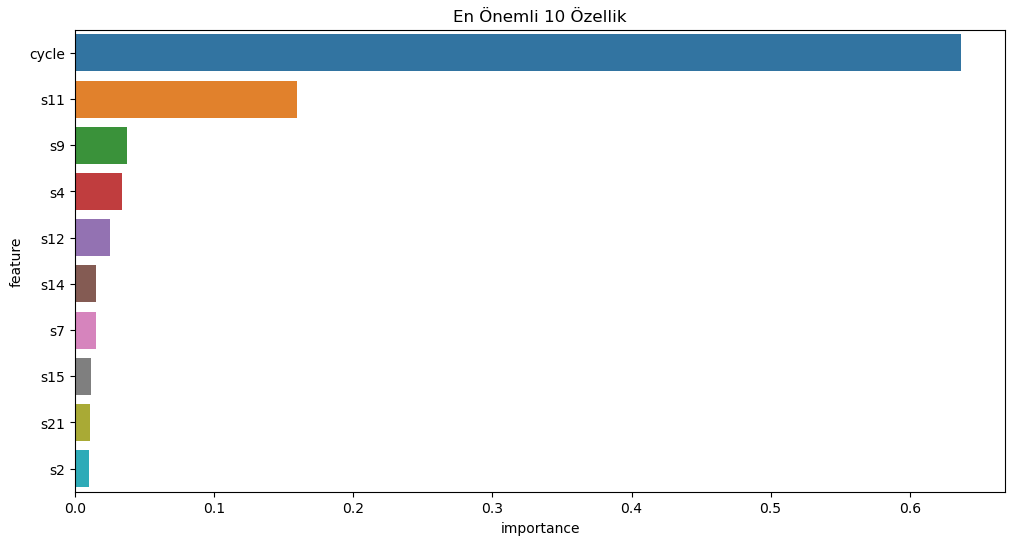

In [17]:
# Özellik önem sıralaması
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('En Önemli 10 Özellik')
plt.show()

In [18]:
# Bakım tahminleri
def format_maintenance_prediction(row):
    id = row['id']
    predicted_rul = row['RUL_predicted']
    hours = round(predicted_rul)
    if hours <= 0:
        return f"Motor ID {id}: ACİL BAKIM GEREKLİ! Tahmini kalan ömür süresi aşılmış."
    elif hours < 50:
        return f"Motor ID {id}: DİKKAT! Yakın zamanda bakım gerekli. Tahmini kalan süre: {hours} saat."
    elif hours < 100:
        return f"Motor ID {id}: Bakım planlanmalı. Tahmini kalan süre: {hours} saat."
    else:
        return f"Motor ID {id}: İyi durumda. Tahmini kalan süre: {hours} saat."

final_predictions['maintenance_message'] = final_predictions.apply(format_maintenance_prediction, axis=1)

print("\nBakım Tahminleri:")
for message in final_predictions['maintenance_message']:
    print(message)


Bakım Tahminleri:
Motor ID 1.0: İyi durumda. Tahmini kalan süre: 173 saat.
Motor ID 2.0: İyi durumda. Tahmini kalan süre: 142 saat.
Motor ID 3.0: Bakım planlanmalı. Tahmini kalan süre: 55 saat.
Motor ID 4.0: Bakım planlanmalı. Tahmini kalan süre: 79 saat.
Motor ID 5.0: Bakım planlanmalı. Tahmini kalan süre: 95 saat.
Motor ID 6.0: Bakım planlanmalı. Tahmini kalan süre: 95 saat.
Motor ID 7.0: İyi durumda. Tahmini kalan süre: 115 saat.
Motor ID 8.0: Bakım planlanmalı. Tahmini kalan süre: 73 saat.
Motor ID 9.0: İyi durumda. Tahmini kalan süre: 134 saat.
Motor ID 10.0: İyi durumda. Tahmini kalan süre: 106 saat.
Motor ID 11.0: Bakım planlanmalı. Tahmini kalan süre: 81 saat.
Motor ID 12.0: Bakım planlanmalı. Tahmini kalan süre: 96 saat.
Motor ID 13.0: Bakım planlanmalı. Tahmini kalan süre: 91 saat.
Motor ID 14.0: İyi durumda. Tahmini kalan süre: 146 saat.
Motor ID 15.0: İyi durumda. Tahmini kalan süre: 168 saat.
Motor ID 16.0: İyi durumda. Tahmini kalan süre: 110 saat.
Motor ID 17.0: Bakım p

In [19]:
# Accuracy hesaplama
def calculate_accuracy(y_true, y_pred, threshold=100):
    y_true_class = (y_true <= threshold).astype(int)
    y_pred_class = (y_pred <= threshold).astype(int)
    accuracy = accuracy_score(y_true_class, y_pred_class)
    conf_matrix = confusion_matrix(y_true_class, y_pred_class)
    class_report = classification_report(y_true_class, y_pred_class)
    return accuracy, conf_matrix, class_report

y_true = final_predictions[true_rul_column].values
y_pred = final_predictions['RUL_predicted'].values

accuracy, conf_matrix, class_report = calculate_accuracy(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.8100

Confusion Matrix:
[[27  6]
 [13 54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.82      0.74        33
           1       0.90      0.81      0.85        67

    accuracy                           0.81       100
   macro avg       0.79      0.81      0.80       100
weighted avg       0.83      0.81      0.81       100



In [20]:

# Farklı eşik değerleri için accuracy hesapla
thresholds = [50, 100, 150, 200]
for threshold in thresholds:
    acc, _, _ = calculate_accuracy(y_true, y_pred, threshold)
    print(f"Accuracy (threshold={threshold}): {acc:.4f}")

Accuracy (threshold=50): 0.9000
Accuracy (threshold=100): 0.8100
Accuracy (threshold=150): 0.9300
Accuracy (threshold=200): 1.0000


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Sonuçları kaydet
final_predictions.to_csv('random_forest_predictions.csv', index=False)

In [22]:
import pickle

In [23]:
# Modeli kaydet
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Scaler'ı kaydet
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Model ve scaler başarıyla kaydedildi.")

Model ve scaler başarıyla kaydedildi.
